# EEMD + LSTM

In [19]:
# DataFrame
import pandas as pd
import numpy as np
import random
from datetime import datetime, date
import matplotlib.dates as mdates
import matplotlib

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

#Save the log
import os
import time
import pickle
import tempfile

# Lasso
from sklearn.linear_model import Lasso

# EEMD
from PyEMD import EEMD

# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, Bidirectional, RepeatVector, TimeDistributed
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Optimize
from keras_tuner.tuners import RandomSearch

# Metric 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score

---

## EEMD
    * 시계열 그래프를 ensembled IMF (앙상블 내재모드 함수)로 분해
    * n 개의 eIMFs와  1개의 Residual 생성

In [20]:
def eemd_fit(df):
    # Define signal
    t = np.array(df['Date']) # x-axis
    s = np.array(df['y']) # y-axis

    # EEMD 객체 생성
    eemd = EEMD() # trials: EMD 횟수(default:100)
    
#     # 극값을 감지하는 방법으로 parabolic 방법을 선택
#     emd = eemd.EMD
#     emd.extrema_detection="parabol"
    
    # eIMFs로 분해
    eIMFs = eemd.eemd(s, t) # max_imf: IMF 제한 개수(-1: 없음)
    nIMFs = eIMFs.shape[0] # eIMF의 개수
    
    # 분해된 eIMFs와 잔차를 변수에 할당
    imfs, residue = eemd.get_imfs_and_residue()
    
    # 앙상블 IMFs 들의 DataFrame 생성
    all_eIMFs_df = pd.DataFrame(eIMFs).transpose() 
    all_eIMFs_df[nIMFs] = residue # residue 열 마지막 열로 추가
    all_eIMFs_df.insert(0, 'Date', df['Date']) # Date 열 추가
    
    # IMF & Residue 시각화
    plt.figure(figsize=(12, nIMFs*2)) # Figure size 설정
    for i in range(nIMFs):
        plt.subplot(nIMFs+1, 1, i+1) # i번째 subplot
        plt.plot(df['Date'], all_eIMFs_df[i], 'g')
        plt.title('IMF '+str(i+1), fontsize=10)

    # Residue plot
    plt.subplot(nIMFs+1, 1, nIMFs+1)
    plt.plot(df['Date'], all_eIMFs_df[nIMFs], 'r')
    plt.title('Residue', fontsize=10)

    plt.tight_layout()
    plt.show()
    
    return all_eIMFs_df, nIMFs # eIMF+Residue들로 이루어진 df, eIMF의 개수

### eIMFs 데이터프레임 추출

In [21]:
# eIMF들을 추출하여, Date와 y로 이루어진 데이터프레임 추출하고 딕셔너리에 저장
def extract_eIMFs(all_eIMFs_df, nIMFs):
    all_eIMFs_dict = {}
    # IMF개수+Residue(1) 만큼 반복
    for i in range(nIMFs+1):
        tmp_df = all_eIMFs_df[['Date', i]] # n번째 eIMF에 해당하는 날짜와 값 추출
        tmp_df.columns=['Date', 'y'] # i -> y 로 열이름 변경
        all_eIMFs_dict[f'eIMFs_{i}'] = tmp_df # n번째 eIMF 정보(마지막은 Residue) 딕셔너리에 저장
                            # df.columns = ['Date', 'y']
    return all_eIMFs_dict # {eIMFs_1: df1, eIMFs_2: df2, ...}

### Split the train and test set
- Input
     data: dataframe with dates and Demand data
     
- output
    - train: ~ 2012-06-30
    
    - test :  2022-07-01 ~ 2012-12-31

In [22]:
def lasso_feature_selection(df):
    tmp_df = df.drop(columns=['Date','Product', '월', '일', '요일', '년월'])
    # 데이터프레임에서 y값 열 추출
    y = tmp_df.loc[:, 'y']
    
    # 데이터프레임에서 y값 열을 제외한 나머지 열을 X로 설정
    X = tmp_df.drop(columns='y')
    
    # Lasso 회귀 모델 생성
    lasso = Lasso(alpha=1)  # alpha 값을 조절하여 정규화 강도 조절 가능
    
    # 모델 훈련
    lasso.fit(X, y)
    
    # 각 변수의 계수 출력
    coefficients = pd.Series(lasso.coef_, index=X.columns)
    print("각 변수의 계수:")
    print(coefficients)
    
    # 선택된 변수만 보여주기
    selected_var = coefficients[coefficients != 0]
    print("\n선택된 변수:")
    print(selected_var)
    
    return selected_var.index.tolist()

In [23]:
def split_data(product_df, eIMF_df, time_steps): 

    train_end = len(product_df[product_df['Date']<'2022-07-01'])
    
    selected_features = lasso_feature_selection(product_df)
    selected_features += ['y'] # 종속변수 추가
    
    global n_features 
    n_features = len(selected_features)
    target_idx = selected_features.index('y')
    
    filtered_df = product_df.filter(selected_features)  # y가 아니라 여러 feature들이 들어간다.
    filtered_df['y'] = eIMF_df['y'] # imf로 분해된 y값 filtered_df에 넣기
    
    # Scaling
    sc = MinMaxScaler() 
    y_train_scaled = sc.fit_transform(filtered_df.iloc[:train_end, :])
    
    X_train = [] 
    y_train = []
    for i in range(time_steps, train_end-1):
        X_train.append(y_train_scaled[i-time_steps:i, :])  # 여러 feature들의 time steps 만큼의 데이터
        y_train.append(y_train_scaled[i, target_idx])  # target 변수 (예: 'y')
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))  # feature 개수를 반영
    
    y_test_scaled = sc.transform(filtered_df.iloc[train_end:, :])
    
    X_test = []
    y_test = product_df.iloc[train_end+time_steps:].copy()
    y_test['y'] = eIMF_df['y'].iloc[train_end+time_steps:]
    
    y_test['y_norm'] = y_test_scaled[time_steps:, target_idx]  
    
    for i in range(time_steps, len(y_test_scaled)):
        X_test.append(y_test_scaled[i-time_steps:i, :])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))

    return X_train, y_train, X_test, y_test, sc

## Optimized LSTM

In [24]:
def build_model(hp):
    model = Sequential()
    # 2개의 LSTM Layers
    model.add(LSTM(units=hp.Int('units_1', min_value=128, max_value=320, step=64),
                   activation='tanh',
                   return_sequences=True, 
                   input_shape=(None, n_features)))
    
    model.add(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=32),
                   activation='tanh',
                   return_sequences=False))

    model.add(Dense(units=hp.Int('dense_unit', min_value=16, max_value=128, step=16),
                    activation='tanh'))
        
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])

    return model

# 모델 학습 및 평가 함수
def optimize_model(X_train, y_train, X_test, sc, epochs, trials):
    # 진행 상황 저장 할 필요없어서, 임시 경로 생성
    with tempfile.TemporaryDirectory() as temp_dir:
        tuner = RandomSearch(
            build_model,
            objective='loss',
            max_trials= trials,
            directory=temp_dir,
            project_name='temp_project')

    tuner.search_space_summary()

    # 최적의 조합 탐색
    tuner.search(X_train, y_train,
                 epochs=epochs,
                 batch_size=8)

    tuner.results_summary()

    best_model = tuner.get_best_models(num_models=1)[0]

    # Test 데이터 예측값
    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # 예측값을 저장하되, normalize된 값 저장
    
    pred_expanded = np.zeros((pred.shape[0], n_features))
    pred_expanded[:,0] = pred.ravel()  # 첫 번째 feature에 pred 값을 채움
    
    # inverse_transform 적용
    pred = sc.inverse_transform(pred_expanded)
    pred = pred[:, 0]  # 원하는 첫 번째 feature만 선택
    
    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

### EEMD+LSTM

In [25]:
'''
EEMD의 결과로 분해된 ensembled IMF들에 대해
각각 LSTM으로 예측하여 예측값을 얻은 후,
마지막에 합산하여 전체 결과를 파악함
'''
def EEMD_LSTM(product_df, all_eIMFs_dict, time_steps, epochs, trials):

    model_dict = {}
    pred_dict = {}
    print(epochs)
    # 모든 eIMF에 대해 LSTM 모델 학습 및 예측 실행
    for i in all_eIMFs_dict.keys():
        print(f'--------Total: 0~{len(all_eIMFs_dict)-1} eIMFs, Now: {i} --------')
        
        # 현재 eIMF 데이터 가져오기
        eIMF_df = all_eIMFs_dict[i]
        
        # 학습 데이터와 테스트 데이터 분리
        X_train, y_train, X_test, y_test, sc = split_data(product_df, eIMF_df, time_steps)
        
        # LSTM 모델 학습 및 저장
        best_model, pred, pred_norm = optimize_model(X_train, y_train, X_test, sc, epochs, trials)
        
        # imf 진행될수록  IMF 20씩 감소
        epochs = round(epochs / 1.2) 
        
        # When you use a saved model
        # best_model, pred, pred_norm = use_saved_model(X_test, path)
        model_dict[i] = best_model # 딕셔너리에 모델 정보 저장
        
        # 예측 결과 저장
        y_test.reset_index(drop=True, inplace=True)
        pred_df = pd.DataFrame({'Pred': pred.reshape(-1) ,'Pred_norm': pred_norm.reshape(-1)})
        res_df = pd.concat([y_test, pred_df], axis=1)
        
        res_df.set_index('Date', inplace=True)
        res_df.index = pd.to_datetime(res_df.index)
        # res_df: ['y', 'y_norm', 'Pred', 'Pred_norm'], index='Date'
        pred_dict[i] = res_df
        
    # 모델과 예측값 딕셔너리 반환
    return model_dict, pred_dict

### Total Result

In [26]:
def make_all_result_df(pred_dict):
    all_df = pd.DataFrame()
    for tmp_df in pred_dict.values():
        all_df = pd.concat([all_df, tmp_df], axis=1)
        
    pred_df = all_df['Pred'].sum(axis=1)
    actual_df = all_df['y'].sum(axis=1)
    
    all_result_df = pd.DataFrame({'Pred': pred_df, 'y': actual_df})
    all_result_df.loc[all_result_df['Pred']<0, 'Pred']=0 # 음수 예측 값은 0으로 대치
    
    return all_result_df

## Plot the result

In [47]:
def actual_pred_plot(product_code, pred_dict, all_result_df, metric_df):
    today = date.today()
    """
    Plot the actual vs predition and save the figure in the given directory
    """
    # 전체 결과도 PLOT 하기 위해 딕셔너리에 추가
    pred_dict['all_result'] = all_result_df
    
    save_path = os.path.join("Result", "Lasso+EEMD+LSTM_Result", product_code)
        
    for i, res_df in enumerate(pred_dict.values()):
        img_n = len(pred_dict)
        title = f"Pred Actual Plot - ({i+1}/{len(pred_dict)-2})'s eIMF"
        if i == img_n-2: title = "Residue"
        actual = res_df['y']
        pred = res_df['Pred']
        save_name = f'{product_code}_eIMF_{i+1}'
        
        if i == img_n-1: # All result
            title = f"{product_code}-All Result"
            save_name = f'{product_code}_all_result'

        # Pred-Actual Plot
        plt.figure(figsize=(16, 8))
        plt.title(title, fontsize=20)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Order Demand", fontsize=14)
        plt.plot(res_df.index, actual, label ='Actual', color='r', marker='o', ms=3)
        plt.plot(res_df.index, pred, label='Prediction',color='b', marker='o', ms=3)
        
        # x축의 주요 틱 위치를 매 월 첫날로 설정하고, 라벨을 해당 월로 표시
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.legend(loc="upper right")
        
        # Plot 결과 저장
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        # save the figure
        today_date = f'_{today.month:02d}{today.day:02d}'
        plt.savefig(os.path.join(save_path, save_name+'.png'))
        plt.show()
        
    # Metric도 함께 저장
    metric_df.to_csv(os.path.join(save_path, f'{product_code}_Metric.csv'), encoding="utf-8-sig")
    all_result_df.to_csv(os.path.join(save_path, f'{product_code}_total_result.csv'), encoding="utf-8-sig")
    del pred_dict['all_result']
        
    plt.close('all') # close all figures to free up memory

## Save and Load the model

In [48]:
def save_model(product_code, model_dict):
    today = date.today()
    folder_path = 'Result/Lasso+EEMD+LSTM_Result/Model'
    file_name = f'{product_code}_{today.month:02d}{today.day:02d}.pkl'
    save_path = os.path.join(folder_path, file_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    # 객체를 pickle 파일로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(model_dict, f)
    return 

In [49]:
def use_saved_model(X_test, path):
    # 모델 파일 경로
    model_path = path
    
    # 모델 로드
    with open(model_path, 'rb') as file:
        lstm_model = pickle.load(file)
    lstm_model.summary()

    pred = best_model.predict(X_test) # 예측값 얻기
    pred_norm = pred # 예측값을 저장하되, normalize된 값 저장
    pred = sc.inverse_transform(pred.reshape(pred.shape[0], pred.shape[1]))
    
    best_model.summary()
    # 모델 객체와 예측값 반환
    return best_model, pred, pred_norm

## Metrics

In [50]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / (actual+1)))

# 정규화 된 지표
def nrmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred, squared=False)
    target_mean = np.mean(y_true)
    nrmse = mse / target_mean
    return nrmse

# 정규화 된 지표
def nmae(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    target_mean = np.mean(y_true)
    nmae = mae / target_mean
    return nmae

In [51]:
def calculate_metrics(pred_df):
    # 계산된 메트릭을 저장하기 위해 데이터프레임 초기화
    metric_df = pd.DataFrame(columns=['MAPE',
                                      'RMSE',
                                      'MAE',
                                      'NRMSE',
                                      'NMAE',
                                      'R2'])
    
    actual = pred_df['y']
    pred = pred_df['Pred']

    # 메트릭 계산
    MAPE = mape(actual, pred) 
    RMSE = mean_squared_error(actual, pred)**0.5 
    MAE = mean_absolute_error(actual,pred) 
    NRMSE = nrmse(actual,pred) 
    NMAE = nmae(actual,pred) 
    R2 = r2_score(actual, pred)

    # 계산된 메트릭을 데이터프레임에 추가
    tmp_df = pd.DataFrame({'MAPE':[round(MAPE, 4)],
                           'RMSE':[round(RMSE, 4)],
                           'MAE':[round(MAE, 4)],
                           'NRMSE':[round(NRMSE, 4)],
                           'NMAE':[round(NMAE, 4)],
                           'R2': [round(R2, 4)]})

    # 메트릭 데이터프레임에 결과 추가
    metric_df = pd.concat([metric_df, tmp_df])
    return metric_df

---

## Check the Result

In [52]:
def make_metric_df(product_code, pred_dict, all_result_df):
    today = date.today()

    metric_df = pd.DataFrame(columns=['MAPE', 'RMSE', 'MAE', 'NRMSE', 'NMAE', 'R2'])
    for i, pred_df in pred_dict.items():
        imf_df = calculate_metrics(pred_df)
        metric_df = pd.concat([metric_df, imf_df])
    
    imf_idx = pd.Index(['eIMF_'+str(i+1) for i in range(len(pred_dict))]) # changed result_dict to pred_dict
    metric_df.index = imf_idx # Assign the created index to metric_df
    
    # 마지막 행은 전체 결과
    metric_df = pd.concat([metric_df, calculate_metrics(all_result_df)], axis=0)
    metric_df = metric_df.rename(index={metric_df.index[-1]: 'All'}) 
    
    return metric_df

In [53]:
def execute_EEMD_LSTM(product_code, time_steps=1, epochs=1, optimize_trials=1):
    start_time = time.time()
    product_df = df[df['Product']== product_code].reset_index(drop=True)
    
    # EEMD 수행
    all_eIMFs_df, nIMFs = eemd_fit(product_df)
    # EEMD 결과에서 각 eIMFs' DF 추출
    all_eIMFs_dict = extract_eIMFs(all_eIMFs_df, nIMFs)
    
    # EEMD+LSTM 실행
    model_dict, pred_dict = EEMD_LSTM(product_df, all_eIMFs_dict, time_steps, epochs, optimize_trials) #dictionary, time_steps, epochs
    save_model(product_code, model_dict)
    all_result_df = make_all_result_df(pred_dict)
    
    # Metric 성능 평가
    metric_df = make_metric_df(product_code, pred_dict, all_result_df)
    # Pred_Actual Plot
    actual_pred_plot(product_code, pred_dict, all_result_df, metric_df)
    
    # 실행시간 확인
    elapsed_time_seconds = time.time() - start_time
    elapsed_time_minutes = elapsed_time_seconds / 60
    print("실행 시간: {:.2f} 분".format(elapsed_time_minutes))
    return metric_df

---

## Whole Process
    - product_code에 str으로 예측하고자 하는 코드를 입력

In [54]:
# Minus
matplotlib.rcParams['axes.unicode_minus'] = False
# 한글
plt.rc('font', family='NanumGothic')

In [55]:
df = pd.read_csv("../Data/JW/JW_capstone_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [46]:
for code in df['Product'].unique():
    print("==================================")
    print(f"========== { code } ==========")
    print("==================================")
    execute_EEMD_LSTM(code)

Trial 1 Complete [00h 00m 04s]
loss: 0.15131333470344543

Best loss So Far: 0.15131333470344543
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\Users\7info\AppData\Local\Temp\tmp2o1vlwnv\temp_project
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0 summary
Hyperparameters:
units_1: 192
units_2: 192
dense_unit: 64
learning_rate: 0.01
Score: 0.15131333470344543
6/6 [==============================] - 1s 3ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 192)         158208    
                                                                 
 lstm_1 (LSTM)               (None, 192)               295680    
                                                                 
 dense (Dense)               (None, 64)                12352     
                              

C:\Users\7info\anaconda3\envs\EEMD+LSTM\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e+07, tolerance: 4.277e+04
  model = cd_fast.enet_coordinate_descent(


Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 320, 'step': 64, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dense_unit (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
320               |320               |units_1
192               |192               |units_2
48                |48                |dense_unit
0.0001            |0.0001            |learning_rate



KeyboardInterrupt: 

Trial 1 Complete [00h 00m 04s]
loss: 0.08739273250102997

Best loss So Far: 0.08739273250102997
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in C:\Users\7info\AppData\Local\Temp\tmptoe9wm8_\temp_project
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 0 summary
Hyperparameters:
units_1: 192
units_2: 160
dense_unit: 32
learning_rate: 0.001
Score: 0.08739273250102997
6/6 [==============================] - 1s 3ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 192)         158208    
                                                                 
 lstm_1 (LSTM)               (None, 160)               225920    
                                                                 
 dense (Dense)               (None, 32)                5152      
                             

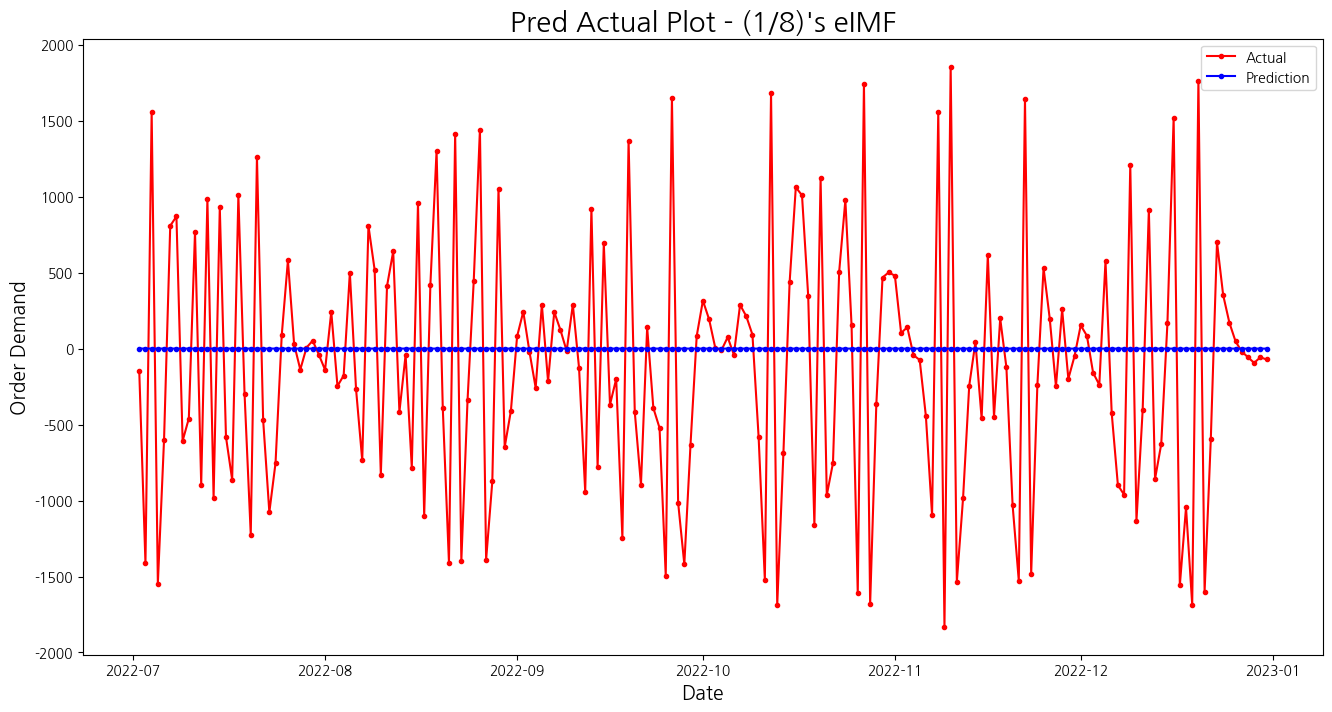

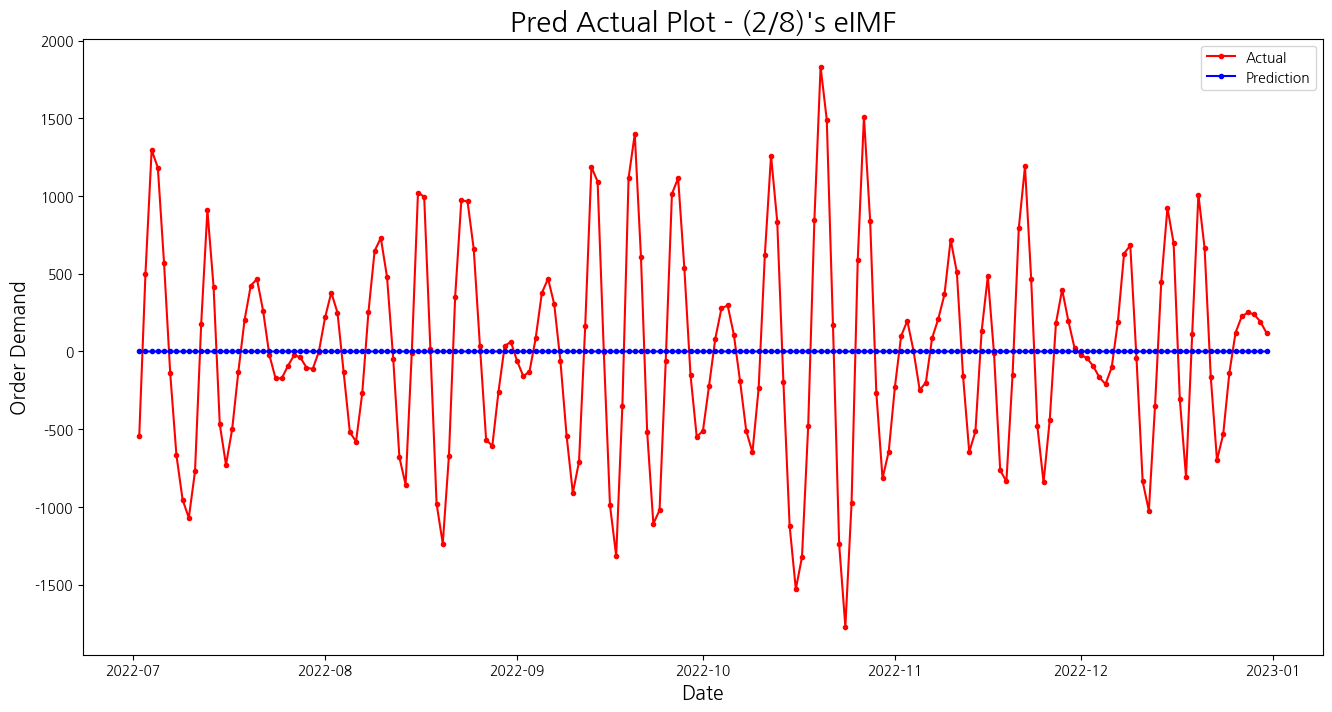

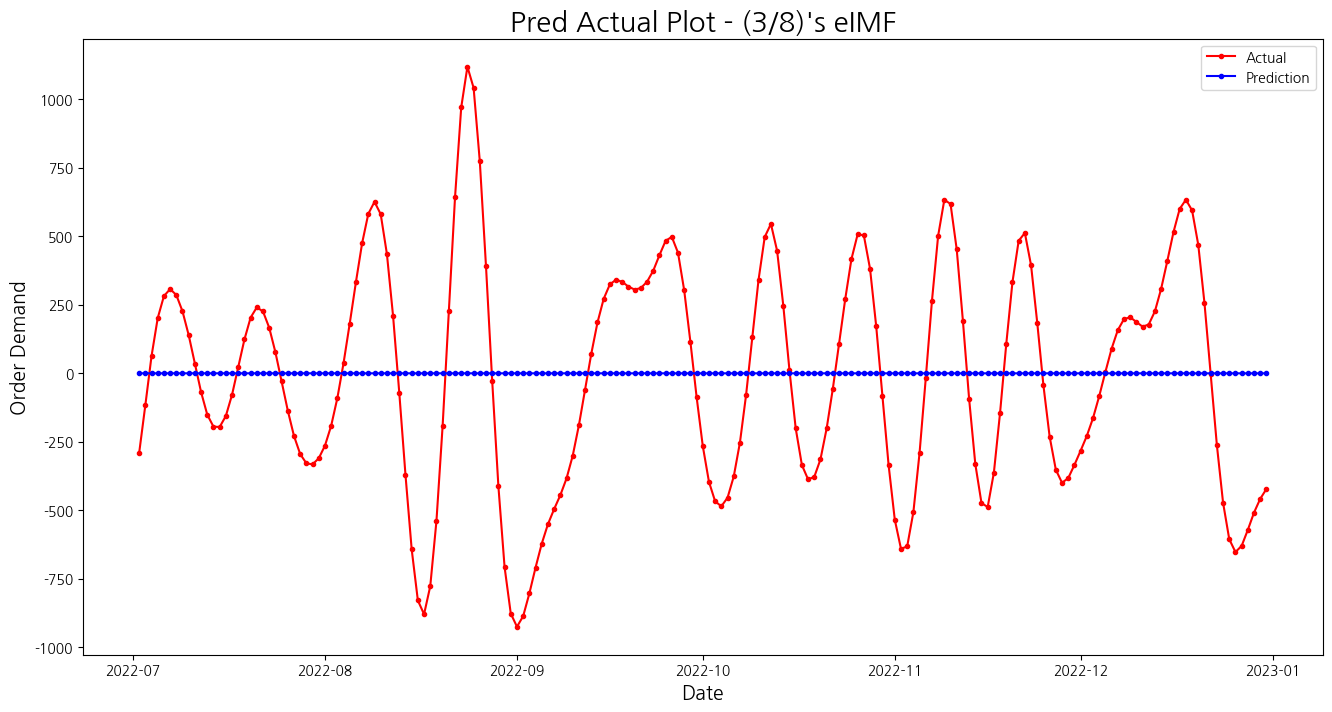

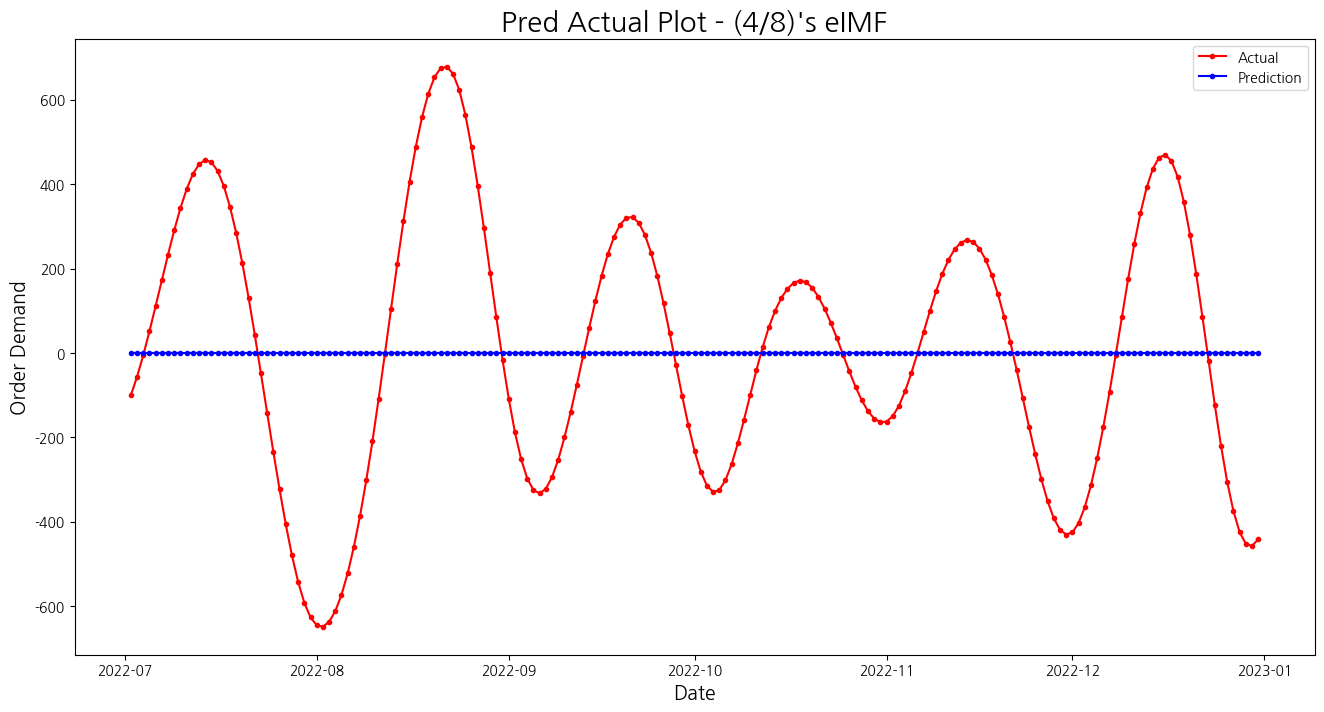

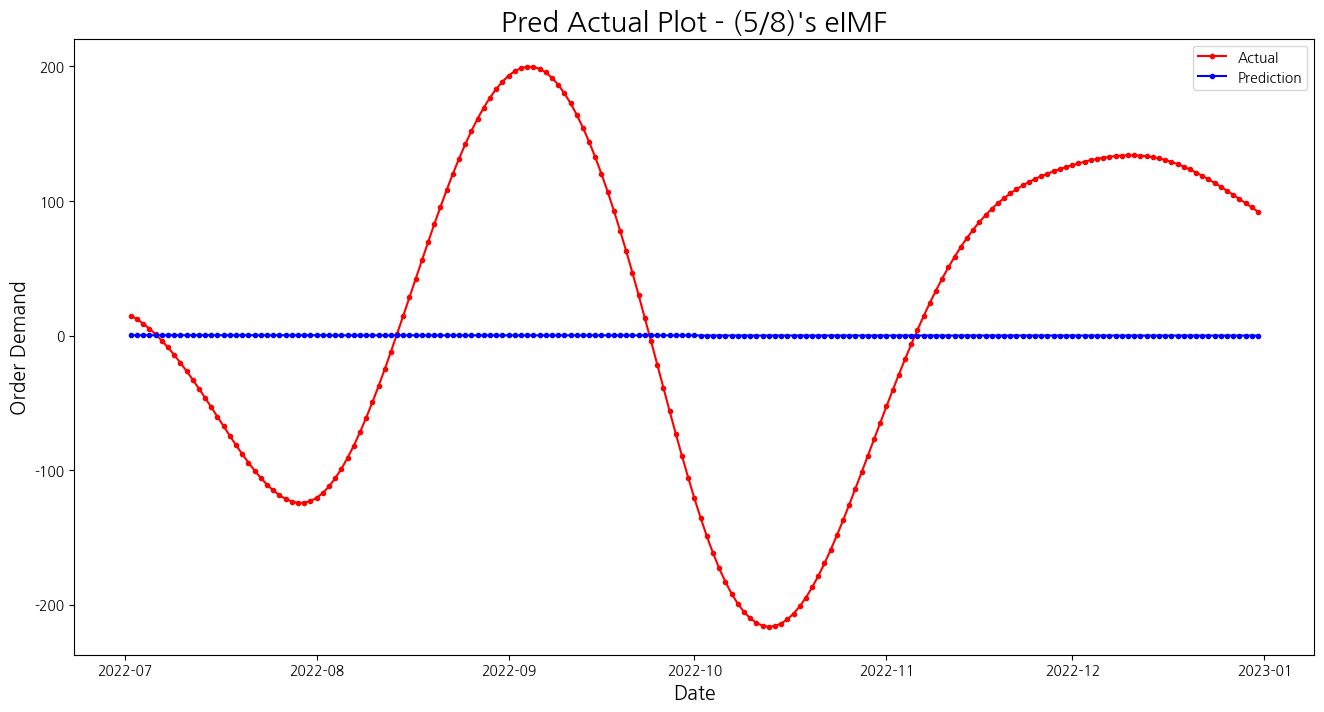

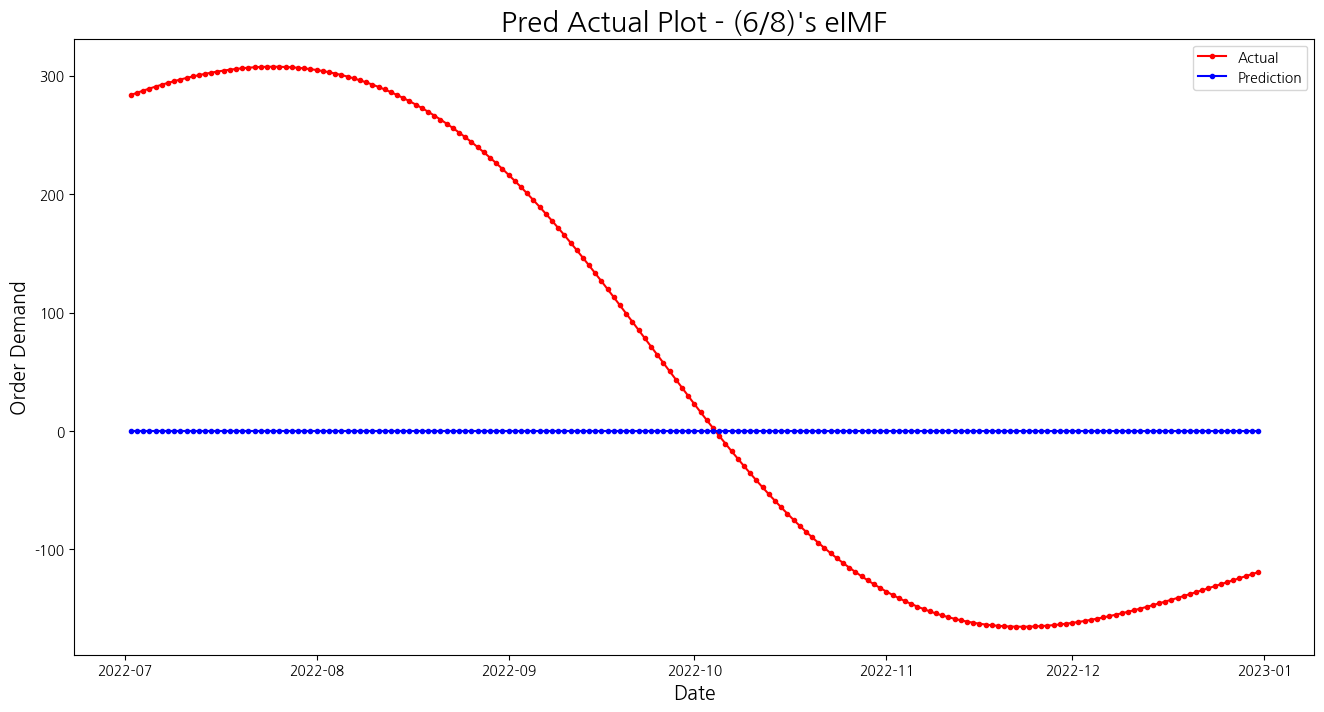

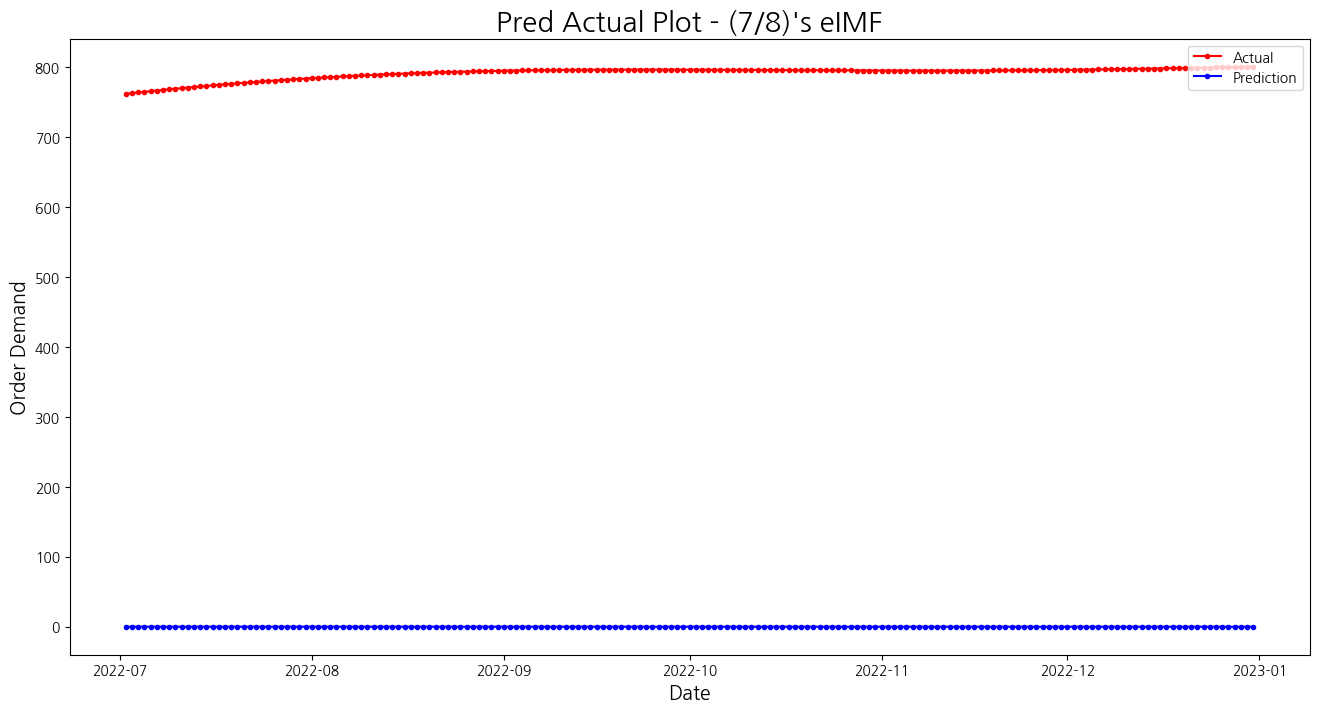

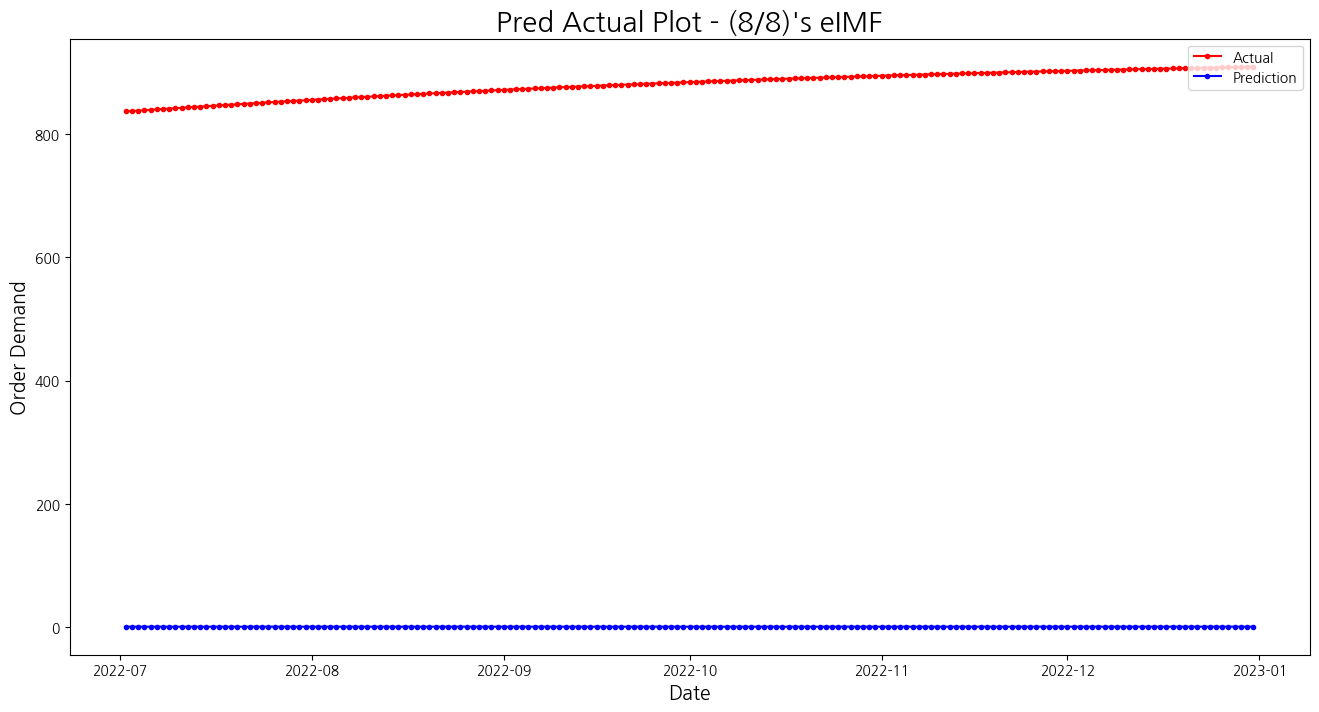

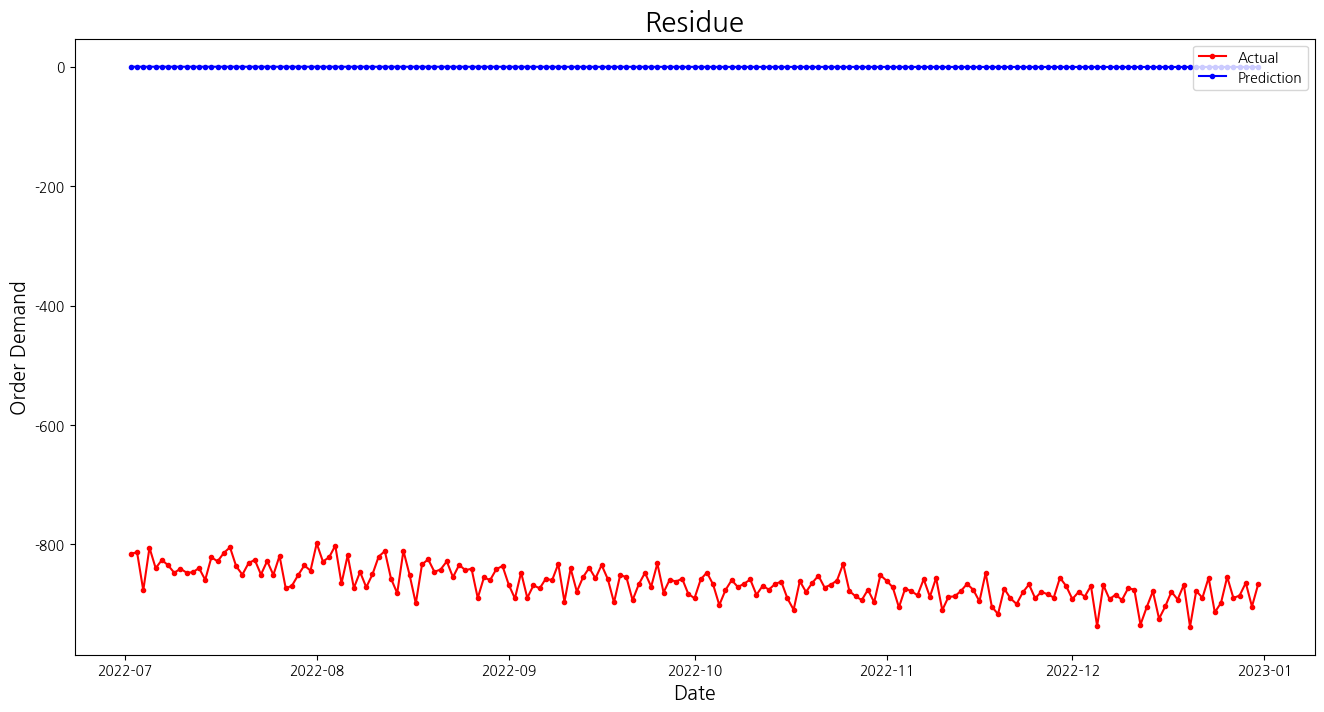

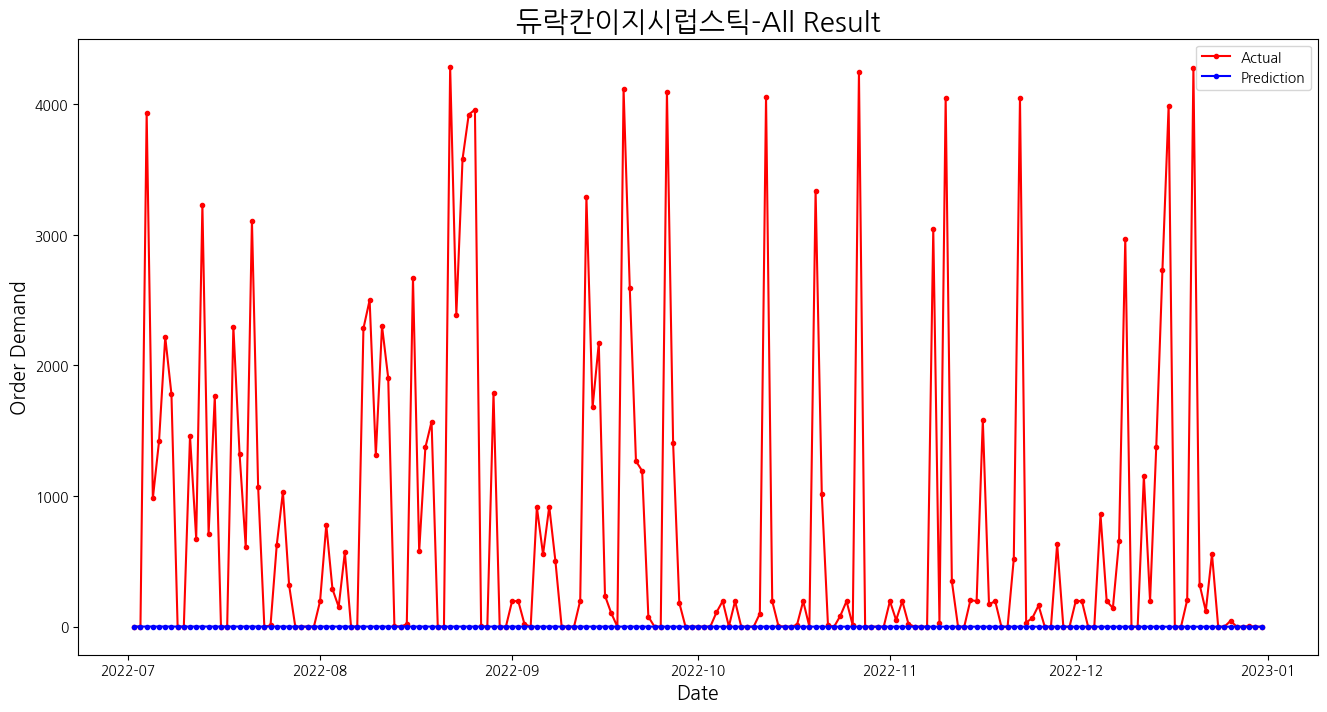

실행 시간: 0.97 분


,MAPE,RMSE,MAE,NRMSE,NMAE,R2
eIMF_1,0.9999,846.3031,666.4245,-8.3252,-6.5557,-0.0147
eIMF_2,1.0338,655.1907,512.2389,155.8293,121.8300,-0.0000
eIMF_3,1.0012,414.9525,349.7713,-42.7934,-36.0713,-0.0005
eIMF_4,1.0032,312.1424,260.2488,31.3316,26.1227,-0.0010
eIMF_5,0.9969,121.8949,107.4676,8.8383,7.7922,-0.0127
eIMF_6,1.0014,198.4611,177.8880,3.5744,3.2038,-0.0845
eIMF_7,0.9987,792.1231,792.0743,1.0000,1.0000,-8144.6139
eIMF_8,0.9981,880.3250,880.0776,0.9995,0.9992,-1776.8951
eIMF_9,1.0010,864.9901,864.5642,-1.0003,-0.9999,-1007.3705
All,0.9134,1446.4422,780.0041,1.8537,0.9996,-0.4090


In [57]:
execute_EEMD_LSTM(df['Product'].unique()[1])